# GAN Project
Jimmy Hickey and David Elsheimer

ST790

01-05-2020

In an effort to keep things self contained, we tried to keep all of the code for each section within that section (aside from the Colab Setup). This is why you will see a lot of repeated code.

Much of our code is adapted from 

* https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
* https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/



# Colab Setup

In [0]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 14.3MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Vanilla GAN MNIST

In [0]:
# example of training a stable gan for generating a handwritten digit
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

from tensorflow.keras import backend as K


# define the standalone discriminator model
def define_discriminator(in_shape=(28, 28, 1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim):
    """Creates a generator model that takes a 100-dimensional noise vector as a "seed",
    and outputs images of size 28x28x1."""
    model = Sequential()
    model.add(Dense(1024, input_dim=latent_dim))
    model.add(LeakyReLU())
    model.add(Dense(128 * 7 * 7))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    if K.image_data_format() == 'channels_first':
        model.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        bn_axis = 1
    else:
        model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))
        bn_axis = -1
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())

    # Because we normalized training inputs to lie in the range [-1, 1],
    # the tanh function should be used for the output of the generator to ensure
    # its output also lies in this range.
    model.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# load mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # select all of the examples for a given class
    selected_ix = trainy == 5
    X = X[selected_ix]
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    pyplot.savefig('results_baseline/plots/plot_%04d.png' % (step + 1))
    pyplot.close()
    # save the generator model
    g_model.save('results_baseline/models/model_%04d.h5' % (step + 1))


# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.close()


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
              (i + 1, d_loss1, d_loss2, g_loss, int(100 * d_acc1), int(100 * d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i + 1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)




In [0]:
import shutil

shutil.rmtree('results_baseline')

# make folder for results
makedirs('results_baseline/models', exist_ok=True)
makedirs('results_baseline/plots', exist_ok=True)

# size of the latent space
latent_dim = 100

n_batch = 64
epochs = 20

# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=epochs, n_batch=64)

(5421, 28, 28, 1)
>1, d1=0.965, d2=0.873 g=0.683, a1=40, a2=9
>2, d1=0.194, d2=1.103 g=0.666, a1=100, a2=3
>3, d1=0.140, d2=1.098 g=0.654, a1=100, a2=3
>4, d1=0.086, d2=0.974 g=0.653, a1=100, a2=12
>5, d1=0.055, d2=0.629 g=0.654, a1=100, a2=59
>6, d1=0.098, d2=0.399 g=0.656, a1=100, a2=96
>7, d1=0.073, d2=0.252 g=0.658, a1=100, a2=100
>8, d1=0.042, d2=0.201 g=0.658, a1=100, a2=100
>9, d1=0.070, d2=0.189 g=0.659, a1=100, a2=100
>10, d1=0.050, d2=0.207 g=0.658, a1=100, a2=100
>11, d1=0.052, d2=0.290 g=0.660, a1=100, a2=100
>12, d1=0.049, d2=0.274 g=0.663, a1=100, a2=100
>13, d1=0.050, d2=0.183 g=0.666, a1=100, a2=100
>14, d1=0.068, d2=0.113 g=0.663, a1=100, a2=100
>15, d1=0.070, d2=0.132 g=0.658, a1=100, a2=100
>16, d1=0.049, d2=0.189 g=0.658, a1=100, a2=100
>17, d1=0.048, d2=0.202 g=0.655, a1=100, a2=100
>18, d1=0.037, d2=0.449 g=0.659, a1=100, a2=96
>19, d1=0.084, d2=0.300 g=0.665, a1=100, a2=100
>20, d1=0.073, d2=0.115 g=0.661, a1=100, a2=100
>21, d1=0.076, d2=0.173 g=0.652, a1=100, a

# WGAN MNIST

In [3]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	critic.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	# selected_ix = trainy == 7 
	# selected_ix += trainy == 5
	# X = trainX[selected_ix]
	X = trainX
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/gdrive/My Drive/Colab Notebooks/results_baseline/plots/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/gdrive/My Drive/Colab Notebooks/results_baseline/models/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('/content/gdrive/My Drive/Colab Notebooks/results_baseline/plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)


#############
#############

#############

#############
#############
#############

from os import makedirs

makedirs('/content/gdrive/My Drive/Colab Notebooks/results_baseline/models', exist_ok=True)
makedirs('/content/gdrive/My Drive/Colab Notebooks/results_baseline/plots', exist_ok=True)

# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim, n_epochs=1)


Using TensorFlow backend.


(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, c1=-1.718, c2=0.005 g=0.025
>2, c1=-5.184, c2=0.094 g=-1.438
>3, c1=-7.624, c2=0.169 g=-2.715
>4, c1=-9.614, c2=0.261 g=-4.388
>5, c1=-11.281, c2=0.356 g=-5.908
>6, c1=-12.823, c2=0.422 g=-6.878
>7, c1=-14.082, c2=0.491 g=-8.075
>8, c1=-15.508, c2=0.575 g=-9.145
>9, c1=-16.231, c2=0.636 g=-10.047
>10, c1=-17.481, c2=0.681 g=-11.073
>11, c1=-18.477, c2=0.761 g=-11.931
>12, c1=-19.053, c2=0.818 g=-12.843
>13, c1=-20.303, c2=0.927 g=-13.803
>14, c1=-20.850, c2=1.035 g=-14.831
>15, c1=-21.833, c2=1.121 g=-16.081
>16, c1=-22.151, c2=1.256 g=-16.652
>17, c1=-22.915, c2=1.405 g=-17.536
>18, c1=-23.789, c2=1.524 g=-18.504
>19, c1=-24.152, c2=1.673 g=-19.227
>20, c1=-24.560, c2=1.775 g=-19.946
>21, c1=-25.372, c2=1.829 g=-20.137
>22, c1=-25.807, c2=1.881 g=-20.353
>23, c1=-25.798, c2=1.856 g=-21.082
>24, c1=-26.927, c2=1.859 g=-21.469
>25, c1=-26.976, c2=1.771 g=-21.995
>26, c1=-27.470, c2=1.702 g=-22.421
>27, c1=-28.122, c2=1.556 g=-22.219
>28, c1=-28.400, c2=1.339 g=-22.832
>29, c1=-29.28

# WGAN Kannada

In [0]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import pandas as pd
from datetime import datetime


latent_dim = 50
n_epochs = 20
n_batch = 16

out_dir = "/content/gdrive/My Drive/Colab Notebooks/wgan_output/kannada_wganwc_epoch"+ str(n_epochs) + "_bsize"+ str(n_batch)+ "_latent_dim" + str(latent_dim)+ "/"

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	critic.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# load images
def load_real_samples():
  kannada_train_url = "https://raw.githubusercontent.com/JimmyJHickey/ST790-Project/master/Kannada-MNIST/train.csv"

  train = pd.read_csv(kannada_train_url)

  X=train.iloc[:,1:].values 
  Y=train.iloc[:,0].values 

  X = X.reshape(X.shape[0], 28, 28,1) 

  X = X.astype('float32')

  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = out_dir + 'plots/generated_plot_%09d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = out_dir + 'models/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig(out_dir + 'plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)


#############
#############

#############

#############
#############
#############

from os import makedirs

print(out_dir)
makedirs(out_dir)

makedirs(out_dir + 'models', exist_ok=True)
makedirs(out_dir + 'plots', exist_ok=True)

# size of the latent space

# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()

# train model
start_time = datetime.now()
train(generator, critic, gan_model, dataset, latent_dim, n_epochs=n_epochs, n_batch = n_batch)
end_time = datetime.now()
print(end_time - start_time)

time_file = out_dir + "time.txt"
with open(time_file, "w") as f:
		f.write("total time\n")
		f.write(str(end_time - start_time))


model_json = generator.to_json()
model_json_path = out_dir + "model.json"

with open(model_json_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")



weight_file = out_dir + "final_weights.txt"

weights = critic.get_weights()

flat_list = [item for sublist in weights for item in sublist]

flatter_list = list()

for i in flat_list:
  flatter_list += i.flatten().tolist() 


with open(weight_file, 'w') as f:
  for item in flatter_list:
    f.write("%s\n" % item)


import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plot_file = "/content/gdrive/My Drive/Colab Notebooks/wgan_output/weight_plots/kannada_wganwc_epoch"+ str(n_epochs) + "_bsize"+ str(n_batch)+ "_latentdim" + str(latent_dim)+ ".png"

num_bins = 1000
n, bins, patches = plt.hist(flatter_list, num_bins, facecolor='red', range = [-0.015, 0.015])
plt.xlabel('Critic Weights')
plt.ylabel('Count')
plt.title(r'WGAN-WC Critic Weights: Epochs=' + str(n_epochs)+ " Batches=" + str(n_batch))
plt.show()

print('WGAN-WC_Critic_Weights:_Epochs={}_Batches={}'.format(str(n_epochs), str(n_batch)))


# Vanilla KANNADA

In [0]:
# example of training a stable gan for generating a handwritten digit
from os import makedirs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
import pandas as pd
from tensorflow.keras import backend as K
from datetime import datetime


# define the standalone discriminator model
def define_discriminator(in_shape=(28, 28, 1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim):
    """Creates a generator model that takes a 100-dimensional noise vector as a "seed",
    and outputs images of size 28x28x1."""
    model = Sequential()
    model.add(Dense(1024, input_dim=latent_dim))
    model.add(LeakyReLU())
    model.add(Dense(128 * 7 * 7))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    if K.image_data_format() == 'channels_first':
        model.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        bn_axis = 1
    else:
        model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))
        bn_axis = -1
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())

    # Because we normalized training inputs to lie in the range [-1, 1],
    # the tanh function should be used for the output of the generator to ensure
    # its output also lies in this range.
    model.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# load mnist images
def load_real_samples(n=60000):
    # load dataset
  kannada_train_url = "https://raw.githubusercontent.com/JimmyJHickey/ST790-Project/master/Kannada-MNIST/train.csv"

  train = pd.read_csv(kannada_train_url)

  X=train.iloc[:,1:].values 
  Y=train.iloc[:,0].values 
  selected_ix = Y==7
  X=X[selected_ix]

  X = X.reshape(X.shape[0], 28, 28,1) 


  X = X.astype('float32')
  
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step + 1))
    pyplot.close()
    # save the generator model
    g_model.save('results_baseline/model_%03d.h5' % (step + 1))


# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(d1_hist, label='d-real')
    pyplot.plot(d2_hist, label='d-fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    # plot discriminator accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.plot(a1_hist, label='acc-real')
    pyplot.plot(a2_hist, label='acc-fake')
    pyplot.legend()
    # save plot to file
    pyplot.savefig('results_baseline/plot_line_plot_loss.png')
    pyplot.close()


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=128):
    # calculate the number of batches per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
              (i + 1, d_loss1, d_loss2, g_loss, int(100 * d_acc1), int(100 * d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i + 1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


# make folder for results
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 50
n_epochs = 20
n_batch = 64

startTime = datetime.now()
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
#train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=n_epochs,n_batch=n_batch)

print(datetime.now() - startTime)

weight_file = out_dir + "final_weights.txt"

weights = discriminator.get_weights()

flat_list = [item for sublist in weights for item in sublist]

flatter_list = list()

for i in flat_list:
  flatter_list += i.flatten().tolist() 


with open(weight_file, 'w') as f:
  for item in flatter_list:
    f.write("%s\n" % item)




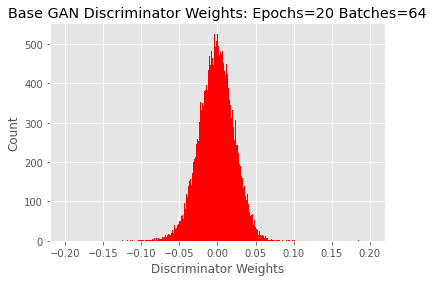

Base_GAN_Discriminator_Weights:_Epochs=20_Batches=64


In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plot_file = "/content/gdrive/My Drive/Colab Notebooks/wgan_output/weight_plots/kannada_wganwc_epoch"+ str(n_epochs) + "_bsize"+ str(n_batch)+ "_latentdim" + str(latent_dim)+ ".png"

num_bins = 1000
n, bins, patches = plt.hist(flatter_list, num_bins, facecolor='red',range = [-0.2, 0.2])
plt.xlabel('Discriminator Weights')
plt.ylabel('Count')
plt.title(r'Base GAN Discriminator Weights: Epochs=' + str(n_epochs)+ " Batches=" + str(n_batch))
plt.show()

print('Base_GAN_Discriminator_Weights:_Epochs={}_Batches={}'.format(str(n_epochs), str(n_batch)))

# RUN SAVED MODEL

In [0]:
from keras.models import model_from_json


# load json and create model
json_file = open('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_full_200epoch/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_full_200epoch/models/model_187400.h5")
print("Loaded model from disk")

makedirs('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_full_200epoch/test_output', exist_ok=True)


Loaded model from disk


In [0]:
def make_output_file(name, g_model, n_samples=100):
	latent_dim = 50
  
  # prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_full_200epoch/test_output/%s.png' % (name)
	pyplot.savefig(filename1)
	pyplot.close()
	print('>Saved: %s' % (filename1))

In [0]:
make_output_file("test3", loaded_model, 100)

>Saved: /content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_full_200epoch/test_output/test3.png


# In Progress Gradient Penalty Implementations

Below are our attempts to get the gradient penalty implemented as well as the sources we were basing our code off of.

The Kaggle one is the closest to working.

## Github
https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py


In [0]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend as K
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers.merge import _Merge
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import pandas as pd

from functools import partial


# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
  return K.mean(y_true * y_pred)

# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py
def gradient_penalty_loss(y_true, y_pred, real_img, fake_img, lam=10):
	"""
	Computes gradient penalty based on prediction and weighted real / fake samples
	"""
	interpolated_img = RandomWeightedAverage()([real_img, fake_img])
	gradients = K.gradients(y_pred, interpolated_img)[0]
	# compute the euclidean norm by squaring ...
	gradients_sqr = K.square(gradients)
	#   ... summing over the rows ...
	gradients_sqr_sum = K.sum(gradients_sqr,
														axis=np.arange(1, len(gradients_sqr.shape)))
	#   ... and sqrt
	gradient_l2_norm = K.sqrt(gradients_sqr_sum)
	# compute (||grad|| - 1)^2 still for each single sample
	expected_parameter =  K.square(gradient_l2_norm - 1)
	# compute mean
	expected_value = K.mean(expected_parameter)
	# multiply by lambda for final penalty
	gradient_penalty = lam * expected_value
	return gradient_penalty

def wgan_gp_loss(y_true, y_pred, real_img, fake_img, lam=10):
	return wasserstein_loss(y_true, y_pred) + gradient_penalty_loss(y_true, y_pred, real_img, fake_img, lam)


# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	# model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	# model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))

	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic, latent_dim, penalty_lambda):
	# make weights in the critic not trainable
	critic.trainable = False


	z_shape = (latent_dim, )

	# hard coded for testing
	img_shape = (28,28,1)

	z = Input(shape=z_shape)

	# Fake image
	f_img = generator(z)
	f_out = critic(f_img)

	# real image
	r_img = Input(shape = img_shape)
	r_out = critic(r_img)

	# average image
	epsilon = K.placeholder(shape=(None,1,1,1))
	a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
	a_out = critic(a_img)

	# real and fake loss
	r_loss = K.mean(r_out)
	f_loss = K.mean(f_out)

	# gradient penalty
	grad_mixed = K.gradients(a_out, [a_img])[0]
	norm_grad_mixed = K.sqrt( K.sum( K.square(grad_mixed), axis=[1,2,3] ) )
	grad_penalty = penalty_lambda * K.mean( K.square( norm_grad_mixed - 1 ) )

	loss = (f_loss - r_loss) + grad_penalty

	# put together the loss functions and compile models
	opt = RMSprop(lr=0.00005)
	critic.compile(loss=loss, optimizer=opt)
 
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=loss, optimizer=opt)
	return model

# load images
def load_real_samples():
  kannada_train_url = "https://raw.githubusercontent.com/JimmyJHickey/ST790-Project/master/Kannada-MNIST/train.csv"

  train = pd.read_csv(kannada_train_url)

  X=train.iloc[:,1:].values 
  Y=train.iloc[:,0].values 

  X = X.reshape(X.shape[0], 28, 28,1) 

  # load dataset
  # (trainX, trainy), (_, _) = load_data()
  # select all of the examples for a given class
  # selected_ix = trainy == 7 
  # selected_ix += trainy == 5
  # X = trainX[selected_ix]
  # X = trainX
  # expand to 3d, e.g. add channels
  # X = expand_dims(X, axis=-1)
  # convert from ints to floats

  X = X.astype('float32')

  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/plots/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/models/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)


#############
#############

#############

#############
#############
#############

from os import makedirs

makedirs('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/models', exist_ok=True)
makedirs('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/plots', exist_ok=True)

dataset = load_real_samples()
print(dataset.shape)

# size of the latent space
latent_dim = 50
n_epochs = 10
lam = 10
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, critic, latent_dim, lam)

# train model
train(generator, critic, gan_model, dataset, latent_dim, n_epochs=n_epochs)

model_json = generator.to_json()
model_json_path = "/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/model.json"

with open(model_json_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")

(60000, 28, 28, 1)


OperatorNotAllowedInGraphError: ignored

## Kaggle
https://www.kaggle.com/amanooo/wgan-gp-keras

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time      # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image
from keras.initializers import RandomNormal

# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend as K
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers.merge import _Merge
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import pandas as pd

kernel_start = time.perf_counter()
kernel_time_limit = 60*60*8.5        #### running time

# image size
img_size = 28
channels = 1
img_shape = (img_size, img_size, channels)  

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 32        # 16 or 64 better?
rec_interval = 10000



def build_generator2():
  input = Input(shape=z_shape)
  x = Dense(4*img_size*img_size, activation="relu")(input)
  x = Reshape((img_size//4, img_size//4, -1))(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(img_size*2, kernel_size=3, strides=1, padding="same",
                  use_bias=False)(x)
  x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
  # x = Conv2D(img_size*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
  # x = Activation("relu")(x)
  # x = Conv2D(img_size*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
  # x = Activation("relu")(x)
  # x = UpSampling2D((2, 2))(x)
  # x = Conv2D(img_size*2, kernel_size=3, strides=1, padding="same",
  #             use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
  # x = Conv2D(img_size*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
  # x = Activation("relu")(x)
  # x = Conv2D(img_size*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
  # x = Activation("relu")(x)
  # x = UpSampling2D((2, 2))(x)
  # x = Conv2D(img_size*1, kernel_size=3, strides=1, padding="same",
  #                 use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
  # x = Conv2D(img_size*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
  # x = Activation("relu")(x)
  # x = Conv2D(img_size*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
  x = Activation("relu")(x)
  x = Conv2D(channels, kernel_size=3, strides=1, padding="same", activation="tanh",
              use_bias=False,)(x)

  model = Model(input, x)
  # print("●generator")
  # model.summary()
  return model


def build_generator():
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7

  input = Input(shape = z_shape)

  x = Dense(n_nodes, kernel_initializer=init)(input)
  x = LeakyReLU(alpha=0.2)(x)
  x = Reshape((7, 7, 128))(x)

  # upsample to 14x14
  x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  # upsample to 28x28
  x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  # output 28x28x1
  x = Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init)(x)

  model = Model(input, x)
  # print("●generator")
  # model.summary()
  return model

def build_discriminator():
  input = Input(shape=img_shape)
  x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
  x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
  x = Flatten()(x)
  x = Dense(units=1, activation=None)(x)   # activation = None
  
  model = Model(input, x)
  # print("●discriminator")
  # model.summary()
  return model


def build_WGANgp(generator, discriminator):
  #### model
  # generator image(fake image)
  z = Input(shape=z_shape)
  f_img = generator(z)
  f_out = discriminator(f_img)
  # real image
  r_img = Input(shape=img_shape)
  r_out = discriminator(r_img)
  # average image
  epsilon = K.placeholder(shape=(None,1,1,1))
  a_img = Input(shape=(img_shape),
                tensor = epsilon * r_img + (1-epsilon) * f_img)
  a_out = discriminator(a_img)

  #### loss
  # original critic(discriminator) loss
  r_loss = K.mean(r_out)
  f_loss = K.mean(f_out)
  # gradient penalty  <this is point of WGAN-gp>
  grad_mixed = K.gradients(a_out, [a_img])[0]
  norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
  grad_penalty = K.mean(K.square(norm_grad_mixed -1))
  penalty = penaltyLambda * grad_penalty
  # d loss
  d_loss = f_loss - r_loss + penalty
  
  #### discriminator update function
  d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
              get_updates(discriminator.trainable_weights,[],d_loss)
  d_train = K.function([r_img, z, epsilon],
                        [r_loss, f_loss, penalty, d_loss],
                        d_updates)
  
  #### generator update function
  g_loss = -1. * f_loss
  g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
              get_updates(generator.trainable_weights,[],g_loss)
  g_train = K.function([z], [g_loss], g_updates)

  return g_train, d_train
  




### 


def load_real_samples():
  kannada_train_url = "https://raw.githubusercontent.com/JimmyJHickey/ST790-Project/master/Kannada-MNIST/train.csv"

  train = pd.read_csv(kannada_train_url)

  X=train.iloc[:,1:].values 
  Y=train.iloc[:,0].values 

  X = X.reshape(X.shape[0], 28, 28,1) 

  # load dataset
  # (trainX, trainy), (_, _) = load_data()
  # select all of the examples for a given class
  # selected_ix = trainy == 7 
  # selected_ix += trainy == 5
  # X = trainX[selected_ix]
  # X = trainX
  # expand to 3d, e.g. add channels
  # X = expand_dims(X, axis=-1)
  # convert from ints to floats

  X = X.astype('float32')

  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/plots/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/models/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('/content/gdrive/My Drive/Colab Notebooks/kannada_results_baseline_gp/plot_line_plot_loss.png')
	pyplot.close()

def sumple_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()



dataset = load_real_samples()

# generator Model
generator = build_generator()
# discriminator Model
discriminator = build_discriminator()
# WGAN-gp Training Model
G_train, D_train = build_WGANgp(generator, discriminator)

# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
d_loss_list = []

X_train = load_real_samples()





iteration = 0
# while time.perf_counter() - kernel_start < kernel_time_limit:

while iteration < 100:
  print("iter: " , iteration)

  #### Discriminator
  for j in range(trainRatio):
      print("discrim: " , j)
      # Generator in
      z = np.random.normal(0, 1, (batch_size, z_dim))
      # Generator out Images
      f_imgs = generator.predict(z)
      # Real Images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      r_imgs = X_train[idx]
      # train the discriminator
      epsilon = np.random.uniform(size = (batch_size, 1,1,1))
      print("epsilon: ", len(epsilon))
      r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

  #### Generator
  # Generator in
  z = np.random.normal(0, 1, (batch_size, z_dim))
  # train the generator
  g_loss = G_train([z])

  #### Record of learning progress
  # loss
  r_loss_list.append(r_loss)
  f_loss_list.append(f_loss)
  f_r_loss_list.append(f_loss - r_loss)
  penalty_list.append(penalty)
  d_loss_list.append(d_loss)
  # generated image sumple
  if (iteration in [100, 1000]) or (iteration % rec_interval == 0):
      print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
      g_imgs = generator.predict(z_fix)
      imgs = g_imgs * 127.5 + 127.5
      sumple_images(imgs, rows=1, cols=7)
      plt.show()

  iteration += 1
    
print("last iteration:",iteration - 1)

Using TensorFlow backend.


iter:  0
discrim:  0
epsilon:  32


FailedPreconditionError: ignored